# Box World Navigation Project

---

This notebook describes the implementation of the Deep Reinforcement Learning agent used to solve the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

This notebook also serves as live and executable documentation. Therefore, there will be a little bit of code and modules imported.

Nevertheless, all the *important* stuff is implemented in the [deeprl](deeprl/) package. So, you are encouraged to take a look at that package as well. A fully trained agent should perform as in the video below (if the video doesn't show automatically, execute the cell manually).

In [1]:
%%HTML
<iframe width="560" height="315"
 src="https://www.youtube.com/embed/B4JKTivr4qA"
    frameborder="0"
    allow="autoplay; encrypted-media" allowfullscreen>
</iframe>

## 1. Loading necessary packages

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the [README](README.md) instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/), and [PyTorch](http://pytorch.org).

If you are running a Windows system, please pay special attention to the README, as the code **will not** be able to automatically execute the environment.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

from deeprl.train import dqn
from deeprl.agent import Agent
from deeprl.model import QNetwork
from deeprl.util import print_source
from deeprl.util import load_environment

INFO:root:Using first CUDA device for computation. Tune visibility by setting the CUDA_VISIBLE_DEVICES env var.


## 2. The algorithm

As aforementioned, this code uses Deep Reinforcement Learning to solve the environment. In particular, we use the Deep Q-Networks (DQN) algorithm.

DQN use *experience replay* and *fixed Q-targets* to be able to "stabilize" the learning process. Overall, the algorithm is:

 * Take action $a_t$ according to an $\epsilon$-greedy policy
 * Store transition $(s_t, a_t, r_{t+1}, s_{t+1})$ in replay memory $\mathcal{D}$
 * Sample random mini-batch of transitions $(s, a, r, s')$ from $\mathcal{D}$
 * Compute Q-learning targets with regards to old, fixed parameters $w^-$
 * Optimize Mean Squared Error between Q-network and Q-learning targets
$$
\mathcal{L}_i(w_i) = \mathbb{E}_{s, a, r, s' \sim \mathcal{D}_i} \left[\left(r + \gamma\max_{a'}Q(s', a'; w_i^-)-Q(s, a; w_i)\right)^2\right]
$$
 * Using a variant of stochastic gradient descent

### 2.1 The optimizer

The variant of stochastic gradient descent we use is the [Adam optimization algorithm](https://arxiv.org/abs/1412.6980).

### 2.2 The network architecture

For this problem, we're using a four-layer fully-connected neural network. Layer sizes are:

 1. `state_size` inputs, 16 outputs
 2. 16 inputs, 32 outputs
 3. 32 inputs, 64 outputs
 4. 64 inputs, `action_size` outputs

Where `state_size` is the size of the state in the current environment (37 for the banana environment), and `action_size` is the size of the actions in the current environment (4 for the banana environment). The PyTorch implementation can be seen in the cell below. 

In [3]:
print_source(QNetwork.__init__)
print_source(QNetwork.forward)

```python
    def __init__(self, state_size: int, action_size: int, seed: int):
        '''Initializes parameters and builds the model.

        Parameters
        ----------
            state_size: int
                Dimensions of each observation
            action_size: int
                Dimensions of the actions
            seed: int
                Random seed
        '''
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.action_size = action_size
        self.state_size = state_size

        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, action_size)

```

```python
    def forward(self, state):
        'Runs the state through the network to generate action values.'

        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)

        return x

```

### 2.3 The actual learning algorithm

With the textual description given above and having the network and optimizer defined, one can devise a learning algorithm written in PyTorch. Assuming `self.qnetwork_target` implements the network that uses weights $w^-$ and `self.qnetwork_local` implements the network that uses weights $w$. The algorithm can be implemented as below (again, the reader is encouraged to read the [full source](deeprl/agent.py)).

Notice that we *do not* fully transition the local weights $w$ to the $w^-$ weights. Rather, we perform a *soft* update, controlled by hyperparameter $\tau$. This allows us to slowly transition from set of weights to the other, giving more smooth operation to the algorithm.

In [4]:
print_source(Agent.learn)

```python
    def learn(self, experiences, gamma):
        '''Updates value parameters using given batch of experience tuples.

        Parameters
        ----------
            experiences: Tuple[torch.Tensor]
                tuple of (s, a, r, s', done) tuples
            gamma: float
                Discount factor
        '''
        states, actions, rewards, next_states, dones = experiences

        # Estimates the TD target R + γ max_a q(S′, a, w−) {{{
        targets_next = self.qnetwork_target.forward(next_states).max(1)[0].unsqueeze(1)
        # By definition, all future rewards after reaching a terminal states are zero.
        # Hence, we use the `dones` booleans to properly assign value to states.
        targets = rewards + (gamma * targets_next * (1 - dones))
        # }}}

        # Now we get what our current policy thinks are the values of the actions
        # we've taken in the past
        estimated = self.qnetwork_local.forward(states).gather(1, actions)

        # We want to minimize the MSE (although this part is super confusing in
        # the DQN paper. Some people say this should be the Huber loss, but that's
        # not what I understood from the code attached to the paper.
        # For more context:
        # https://stackoverflow.com/a/43720168
        loss = F.mse_loss(estimated, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Updating the target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

```

### 2.4 Hyperparameters

As can be seen above, the algorithm has many hyperparameters. The set of hyperparameters used are:

 * $\gamma = 0.99$ (Discount factor)
 * $\tau = 1\times10^{-3}$ (Network soft-update parameter)
 * $\alpha = 5\times10^{-5}$ (Learning rate used in the Adam optimizer)
 * Batch size = 64
 * $|\mathcal{D}| = 100000$ (Size of the replay buffer)
 * Period between target updates = 5 (every 5 episodes we perform a soft update so that $w^- = \tau w + (1 - \tau)w^-$.
 * Since we're using an $\epsilon$-greedy policy, we decay the $\epsilon$ parameter with each episode. For this particular agent, we start with $\epsilon=1$ and decay it by $0.995$ until it reaches $0.001$. Updates to epsilon are, therefore $\epsilon \leftarrow \epsilon * \mathrm{decay}$.
 
## 3 Training and evaluation

### 3.1 Training

With all of the above defined, we can train our agent. Training is performed by the `dqn` function, shown below.

What it does, essentially, is to load the environment, configure the agent with the environment parameters, and execute the learning process by decaying $\epsilon$ and checking whether the solution criterion is met. If it is, then it finishes training and persists the neural network model.

The optimization criterion we're using is achieving an average reward greater than 13 over 100 episodes.

In [5]:
print_source(dqn)

```python
def dqn(env, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.001,
        eps_decay=0.995, solution_threshold=13.0, checkpointfn='checkpoint.pth'):
    """Function that uses Deep Q Networks to learn environments.

    Parameters
    ----------
        n_episodes: int
            maximum number of training episodes
        max_t: int
            maximum number of timesteps per episode
        eps_start: float
            starting value of epsilon, for epsilon-greedy action selection
        eps_end: float
            minimum value of epsilon
        eps_decay: float
            multiplicative factor (per episode) for decreasing epsilon
    """
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]

    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)

    agent = Agent(state_size, action_size, 123)

    scores = []  # All episodes seen over training
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        logging.debug(
            'Episode {}\tAverage Score: {:.2f}'
            .format(i_episode + 1, np.mean(scores_window))
        )
        if i_episode % 100 == 0:
            logging.info(
                'Episode {}\tAverage Score: {:.2f}'
                .format(i_episode + 1, np.mean(scores_window))
            )
        if np.mean(scores_window) >= solution_threshold:
            logging.info(
                'Environment solved in {:d} episodes!'
                .format(i_episode - 99)
            )
            logging.info(
                'Saving checkpoint file at %s', checkpointfn
            )
            agent.save(checkpointfn)
            break
    return agent, scores, i_episode - 99

```

### 3.2 Evaluation

In [6]:
env = load_environment()
agent, scores, episodes = dqn(env, checkpointfn='checkpoint.pth')
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
INFO:root:Episode 1	Average Score: 1.00
INFO:root:Episode 101	Average Score: 0.19
INFO:root:Episode 201	Average Score: 2.18
INFO:root:Episode 301	Average Score: 5.42
INFO:root:Episode 401	Average Score: 8.56
INFO:root:Episode 501	Average Score: 11.89
INFO:root:Environment solved in 480 episodes!
INFO:root:Saving checkpoint file at checkpoint.pth


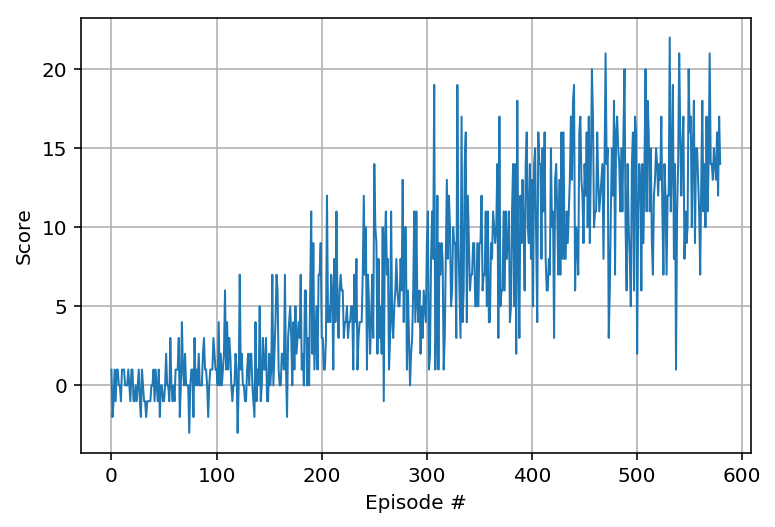

In [7]:
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores, linewidth=1.0)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid()
plt.show()